In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from cbrain.imports import *
from cbrain.utils import *
from matplotlib.animation import FuncAnimation
from IPython.display import SVG, HTML, FileLink

In [132]:
def gw_avg(ds, var):
    return (ds[var] * ds['gw'].values).mean(dim=('lat', 'lon'))

In [10]:
def animate_lat_lon(a, interval=100, **kwargs):
    fig, ax = plt.subplots(1, 1, figsize=(8,5))
    I = ax.imshow(a[1], **kwargs)
    cb = fig.colorbar(I, ax=ax, shrink=0.7)
    T = ax.set_title(f'Step 1')
    def update(i):
        T.set_text(f'Step {i}')
        I.set_data(a[i])
        return I,
    plt.close(fig)
    return FuncAnimation(fig, update, frames=np.arange(1, a.shape[0]), interval=interval, blit=True)

In [5]:
DATA_DIR = '/scratch/05488/tg847872/cloudbrain_ctrl_aquaplanet_03/'
SP_DIR = '/scratch/05488/tg847872/galen_sp/'
NONSP_DIR = '/scratch/05488/tg847872/galen_nonsp/'

In [6]:
%%time
dcbrain = xr.open_mfdataset(f'{DATA_DIR}*debug41b.cam2.h1*.nc', decode_times=False, decode_cf=False, 
                         data_vars=['TPHYSTND', 'PHQ', 'TAP', 'QAP']); 

CPU times: user 12.1 s, sys: 3.94 s, total: 16 s
Wall time: 4min 16s


In [26]:
%%time
dsp = xr.open_mfdataset(f'{SP_DIR}AndKua_aqua_SPCAM3.0_sp.cam2.h1.0000*.nc', decode_times=False, decode_cf=False, 
                         data_vars=['TPHYSTND', 'PHQ', 'TAP', 'QAP']);

CPU times: user 10.6 s, sys: 1.75 s, total: 12.3 s
Wall time: 4min 37s


In [27]:
%%time
dnonsp = xr.open_mfdataset(f'{NONSP_DIR}AndKua_aqua_SPCAM3.0_nonsp_fix.cam2.h1.0000*.nc', decode_times=False, 
                        decode_cf=False, data_vars=['TPHYSTND', 'PHQ', 'TAP', 'QAP']);

CPU times: user 9.26 s, sys: 585 ms, total: 9.84 s
Wall time: 1min 32s


In [108]:
def plot_comparison(var, t, lev=slice(0, None), lon=slice(0, None), **kwargs):
    fig, axes = plt.subplots(1, 3, figsize = (15,4))
    for ax, d in zip(axes.flat, [dcbrain, dsp, dnonsp]):
        d.isel(lon=lon, lev=lev, time=t)[var].plot(ax=ax, add_colorbar=False, **kwargs)

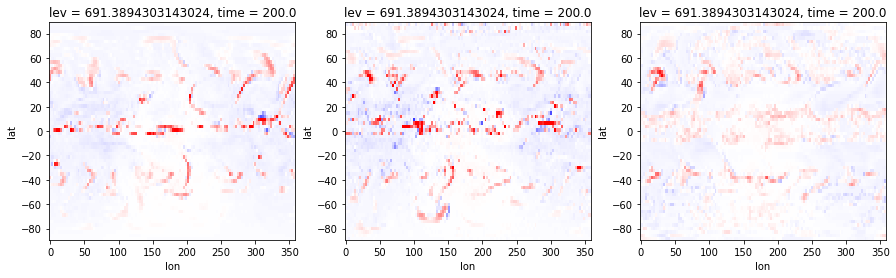

In [109]:
plot_comparison('TPHYSTND', 48*200, 20, vmin=-5e-4, vmax=5e-4, cmap='bwr')

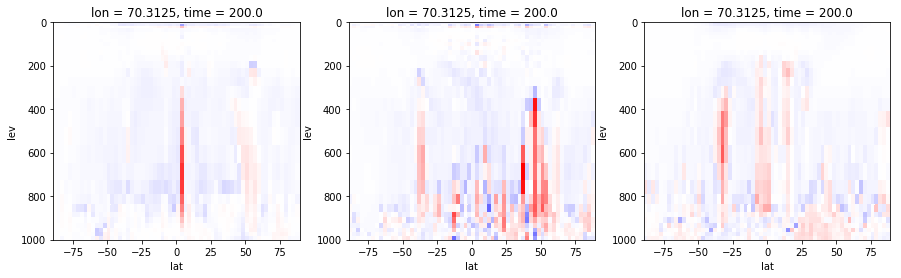

In [98]:
plot_comparison('TPHYSTND', 48*200, lon=25, vmin=-5e-4, vmax=5e-4, cmap='bwr', yincrease=False)

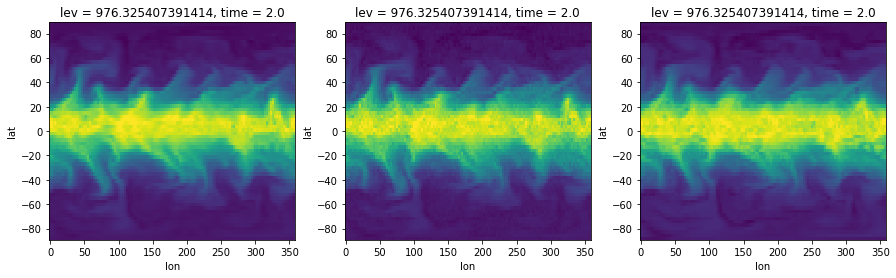

In [61]:
plot_comparison('QAP', 48*2, 28, vmax=0.02, vmin=0.002)

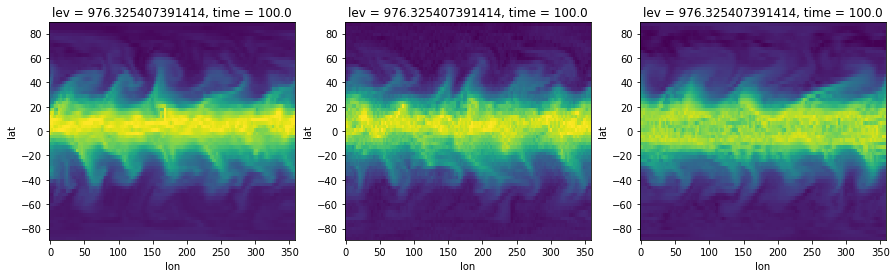

In [85]:
plot_comparison('QAP', 48*100, 28, vmax=0.02, vmin=0.002)

In [113]:
dcbrain['vintTPHYSTND'] = vint(dcbrain, 'TPHYSTND', C_P)
dsp['vintTPHYSTND'] = vint(dsp, 'TPHYSTND', C_P)
dnonsp['vintTPHYSTND'] = vint(dnonsp, 'TPHYSTND', C_P)

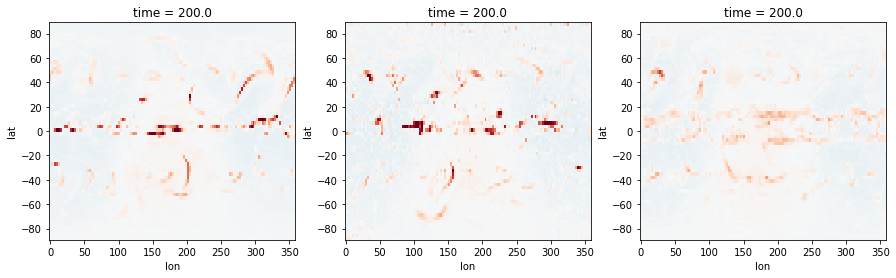

In [117]:
plot_comparison('vintTPHYSTND', 48*200, vmin=-3e3, vmax=3e3, cmap='RdBu_r')

In [118]:
dcbrain['vintTAP'] = vint(dcbrain, 'TAP', C_P)
dsp['vintTAP'] = vint(dsp, 'TAP', C_P)
dnonsp['vintTAP'] = vint(dnonsp, 'TAP', C_P)

In [119]:
dcbrain['gwvintTAP'] = gw_avg(dcbrain, 'vintTAP')
dsp['gwvintTAP'] = gw_avg(dsp, 'vintTAP')
dnonsp['gwvintTAP'] = gw_avg(dnonsp, 'vintTAP')

In [120]:
dcbrain['gwvintTAP']

<xarray.DataArray 'gwvintTAP' (time: 14854)>
dask.array<shape=(14854,), dtype=float64, chunksize=(48,)>
Coordinates:
  * time     (time) float64 0.0 0.02083 0.04167 0.0625 0.08333 0.1042 0.125 ...

KeyboardInterrupt: 

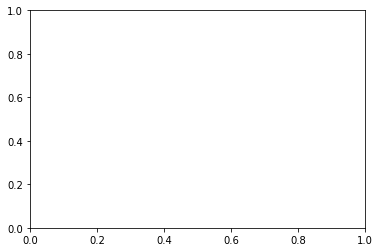

In [133]:
dcbrain['gwvintTAP'].isel(time=slice(1, None, 48*30)).plot(legend='CBRAIN')
dsp['gwvintTAP'].isel(time=slice(1, None, 48*30)).plot(legend='SP')
dnonsp['gwvintTAP'].isel(time=slice(1, None, 48*30)).plot(legend='nonSP')
plt.legend();

In [142]:
def mean_ts(ds): return (ds['TAP'].isel(lev=-1) * ds['gw'] / ds['gw'].mean()).mean(('lat', 'lon'))

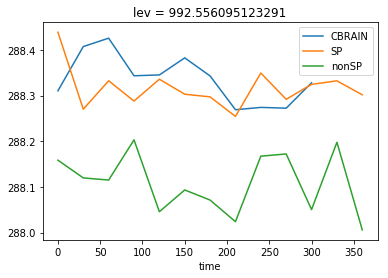

In [144]:
mean_ts(dcbrain.isel(time=slice(1, None, 48*30))).plot(label='CBRAIN')
mean_ts(dsp.isel(time=slice(1, None, 48*30))).plot(label='SP')
mean_ts(dnonsp.isel(time=slice(1, None, 48*30))).plot(label='nonSP')
plt.legend();

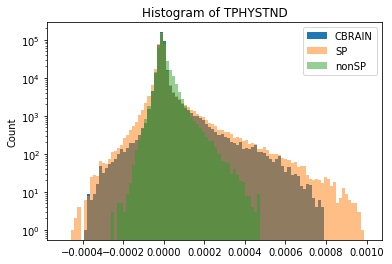

In [146]:
dcbrain['TPHYSTND'].isel(lev=20, time=range(48*2, 48*3)).plot(bins=100, range=(-5e-4, 10e-4), label='CBRAIN')
dsp['TPHYSTND'].isel(lev=20, time=range(48*2, 48*3)).plot(bins=100, range=(-5e-4, 10e-4), alpha=0.5, label='SP')
dnonsp['TPHYSTND'].isel(lev=20, time=range(48*2, 48*3)).plot(bins=100, range=(-5e-4, 10e-4), alpha=0.5, label='nonSP')
plt.gca().set_yscale('log'); plt.legend();

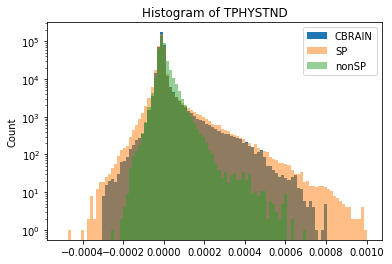

In [147]:
dcbrain['TPHYSTND'].isel(lev=20, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-4, 10e-4), label='CBRAIN')
dsp['TPHYSTND'].isel(lev=20, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-4, 10e-4), alpha=0.5, label='SP')
dnonsp['TPHYSTND'].isel(lev=20, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-4, 10e-4), alpha=0.5, label='nonSP')
plt.gca().set_yscale('log'); plt.legend();

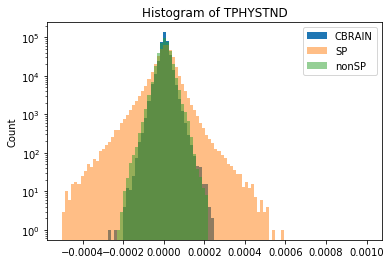

In [154]:
dcbrain['TPHYSTND'].isel(lev=-1, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-4, 10e-4), label='CBRAIN')
dsp['TPHYSTND'].isel(lev=-1, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-4, 10e-4), alpha=0.5, label='SP')
dnonsp['TPHYSTND'].isel(lev=-1, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-4, 10e-4), alpha=0.5, label='nonSP')
plt.gca().set_yscale('log'); plt.legend();

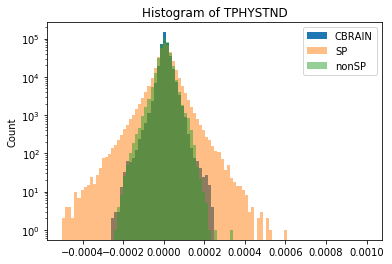

In [155]:
dcbrain['TPHYSTND'].isel(lev=-2, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-4, 10e-4), label='CBRAIN')
dsp['TPHYSTND'].isel(lev=-2, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-4, 10e-4), alpha=0.5, label='SP')
dnonsp['TPHYSTND'].isel(lev=-2, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-4, 10e-4), alpha=0.5, label='nonSP')
plt.gca().set_yscale('log'); plt.legend();

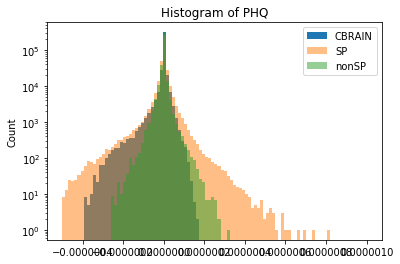

In [150]:
dcbrain['PHQ'].isel(lev=20, time=range(48*2, 48*3)).plot(bins=100, range=(-5e-7, 10e-7), label='CBRAIN')
dsp['PHQ'].isel(lev=20, time=range(48*2, 48*3)).plot(bins=100, range=(-5e-7, 10e-7), alpha=0.5, label='SP')
dnonsp['PHQ'].isel(lev=20, time=range(48*2, 48*3)).plot(bins=100, range=(-5e-7, 10e-7), alpha=0.5, label='nonSP')
plt.gca().set_yscale('log'); plt.legend();

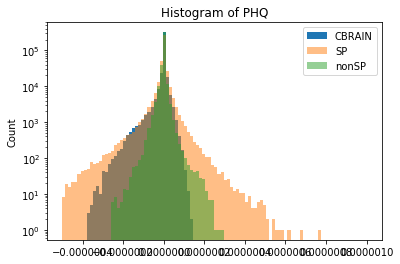

In [151]:
dcbrain['PHQ'].isel(lev=20, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-7, 10e-7), label='CBRAIN')
dsp['PHQ'].isel(lev=20, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-7, 10e-7), alpha=0.5, label='SP')
dnonsp['PHQ'].isel(lev=20, time=range(48*202, 48*203)).plot(bins=100, range=(-5e-7, 10e-7), alpha=0.5, label='nonSP')
plt.gca().set_yscale('log'); plt.legend();

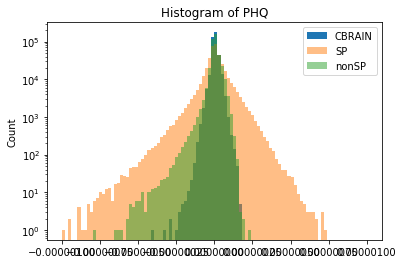

In [153]:
dcbrain['PHQ'].isel(lev=-1, time=range(48*202, 48*203)).plot(bins=100, range=(-10e-7, 10e-7), label='CBRAIN')
dsp['PHQ'].isel(lev=-1, time=range(48*202, 48*203)).plot(bins=100, range=(-10e-7, 10e-7), alpha=0.5, label='SP')
dnonsp['PHQ'].isel(lev=-1, time=range(48*202, 48*203)).plot(bins=100, range=(-10e-7, 10e-7), alpha=0.5, label='nonSP')
plt.gca().set_yscale('log'); plt.legend();

In [12]:
anim = animate_lat_lon(
    dcbrain['TPHYSTND'].isel(lev=20, time=range(0, 48*5, 4)), 
    125, vmin=-7e-4, vmax=7e-4, cmap='bwr'
)

In [14]:
HTML(anim.to_html5_video())